# Regression of 12 month target using features
- **train** 
    - using thresholded_mse on all sequences using normalized features (normalized using retina)
    - use sequence length 1,2,3 (use same number of sequences to train all models)
- **evaluate** 
    - both on all and on "hard" sequences
    - use thresholded_mae and acc as evaluation measure
    - use ELI5 permutation importance to calculate feature importance for models

**Models**:
- mean_baseline: mean of all outcome VAs in the training set
- cur_va_baseline: predict current VA as future VA
- random_forest: scikit-learn random forest regressor concatenating all inputs
- fcnn: fully connected neural network concatenating all inputs

**Permutation Importance**:
measure how the sccore decreases when a feature is not available. Substitute each feature by random permutations of the feature and measure how mse decreases.
https://christophm.github.io/interpretable-ml-book/feature-importance.html


In [1]:
import sys
sys.path.append('../')

from estimators import Estimator, merged_config, plot_train_curve_comparison, plot_train_curve
import models
import importlib
import losses
importlib.reload(losses)
from datasets import IOVar, LongitudinalOCTDataset
from sequences import load_sequences_from_pickle, Measurement
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import logging
from copy import deepcopy
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import eli5
from sklearn.ensemble import RandomForestRegressor

logging.basicConfig(level=logging.INFO) # need one of this?
logging.getLogger().setLevel(logging.INFO) # need one of this?

In [2]:
# load data
workspace_dir = '../../workspace' #'/storage/groups/ml01/workspace/hannah.spitzer/LODE'
fig_dir = 'figures'
features_file = '../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv'
sequences_file = os.path.join(workspace_dir, 'sequences_with_checkup_3-12_dict.pickle')
sequences_all = load_sequences_from_pickle(sequences_file)

In [3]:
default_config = {
    'sequence_data': {
        'load_sequences': False, #True,
        'sequences_fname': sequences_file,
        'features_fname': features_file,
        'num_checkups': 2,
    },
    'sequence_split': {
        'min_len': 3,
        'max_len': None,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': models.SimpleANNModel,
        'input_vars': [IOVar.CUR_VA, IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES],
        'output_vars': [IOVar.CHECKUP2_CUR_VA],
        'norm': [None, None, None, None, None],
        'sequence_length': 1,
        'num_dataloaders': 3,
        'model_kwargs': {
            'encoder_layers': {'num_layers':0},
            'dense_layers': {'num_layers': 2},
            'decoder_layers': {'num_layers': 0},
            'output_layer': {'units': 1, 'activation': None}
        },
        'oversample_classification': False,
    },
    'training': {
        'loss': losses.thresholded_mse_last(0.15),
        'metrics': [losses.thresholded_mae_last(0.15), losses.binary_regression_acc_last(0.15)],
        'batch_size': 512,
        'epochs': 30,
        'learning_rate': 0.01,
    }
}

## Calculate mean_baseline and cur_va_baseline

In [4]:
# get baseline mae
base_est = Estimator(default_config)
base_est.train_dataset, base_est.val_dataset, base_est.test_dataset = base_est.datasets_from_sequences(sequences_all)
default_val_dataset = LongitudinalOCTDataset(base_est.val_dataset.sequences, 
                                             return_values=[IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS],
                                             sequence_length=1, num_inputs=-1)
# cur_va_baseline: current va of val set
cur_va_baseline, y_true, cls_label = default_val_dataset.get_value_list([IOVar.CUR_VA, IOVar.CHECKUP2_CUR_VA, IOVar.CHECKUP2_DIFF_VA_CLASS], batch_size=512)
cls_label = np.argmax(cls_label[:,-1], axis=-1)
# mask for only hard examples (to calculate stricter scores on)
mask_hard = cls_label != 2

# mean_baseline: mean of outcome va on train set
mean_baseline = np.mean(base_est.train_dataset.get_value_list([IOVar.CHECKUP2_CUR_VA])[0][:,-1,0])
mean_baseline = np.ones_like(cur_va_baseline)*mean_baseline

INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-p

resulting norm values [None, None, None, None, None]


## Train random forest on sequences of different lengths (random_forest)

In [8]:
io_vars = (IOVar.CUR_VA, IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES , IOVar.CHECKUP2_CUR_VA)
feature_names = [io_var.value for io_var in io_vars[:-2]]
feature_names += Measurement.FEATURES
# results dict
random_forest = {}

In [148]:
for sl in (1,2,3):

    # get train and val dataset - concatenate into one list of values
    train_dataset = LongitudinalOCTDataset(base_est.train_dataset.sequences, sequence_length=sl, num_inputs=-1,
                                           return_values=io_vars)
    train_dataset = train_dataset.dataset.map(lambda *x: [tf.reshape(tf.concat(x[:-1], axis=1),[-1]), x[-1][-1]])
    train_x = np.array([x.numpy() for x,y in train_dataset])
    train_y = np.array([y.numpy() for x,y in train_dataset])

    val_dataset = LongitudinalOCTDataset(base_est.val_dataset.sequences, sequence_length=sl, num_inputs=-1,
                                         return_values=io_vars)
    val_dataset = val_dataset.dataset.map(lambda *x: [tf.reshape(tf.concat(x[:-1], axis=1),[-1]), x[-1][-1]])
    val_x = np.array([x.numpy() for x,y in val_dataset])
    val_y = np.array([y.numpy() for x,y in val_dataset])
    
    cur_feature_names = ['mmt {} {}'.format(i, n) for i in range(sl) for n in feature_names]

    # train random forest regressor
    clf = RandomForestRegressor(n_estimators=50)
    clf = clf.fit(train_x, train_y.ravel())
    pred = clf.predict(val_x)[:,np.newaxis]
    
    # calculate feature importance
    perm = eli5.sklearn.PermutationImportance(clf).fit(val_x, val_y)
    exp = eli5.explain_weights_df(perm, feature_names=cur_feature_names)

    random_forest['sl{}'.format(sl)] = {'pred_val': pred, 'feature_importance': exp}
    

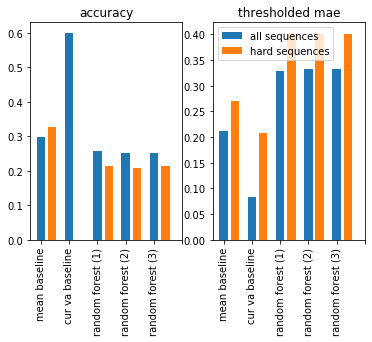

In [149]:
# plot results
names = ['mean baseline', 'cur va baseline', 'random forest (1)', 'random forest (2)', 'random forest (3)']
predictions = [mean_baseline, cur_va_baseline, random_forest['sl1']['pred_val'],
              random_forest['sl2']['pred_val'], random_forest['sl3']['pred_val']]

fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.set_title('accuracy')
scores = [losses.binary_regression_acc_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all sequences')
scores = [losses.binary_regression_acc_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='hard sequences')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=90)

ax = axes[1]
ax.set_title('thresholded mae')
scores = [losses.thresholded_mae_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all sequences')
scores = [losses.thresholded_mae_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='hard sequences')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=90)

axes[-1].legend()

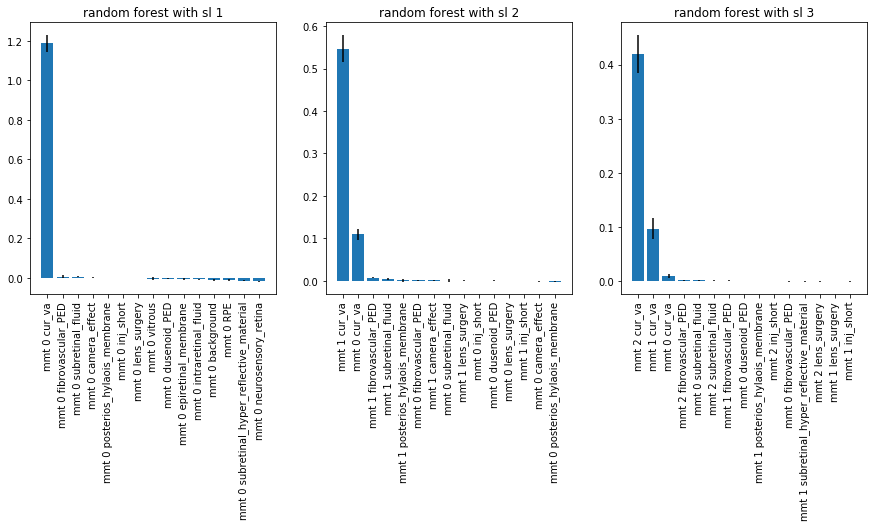

In [147]:
# plot feature importances
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.set_title('random forest with sl {}'.format(i+1))
    exp = random_forest['sl{}'.format(i+1)]['feature_importance']
    ax.bar(exp.index[:15], exp.weight[:15], yerr=exp['std'][:15])
    ax.set_xticks(exp.index[:15])
    ax.set_xticklabels(exp.feature[:15], rotation=90)

## Train fully connected neural network on different sequence lengths

In [5]:
def reshaped_dataset(dataset):
    features = dataset.dataset.map(lambda *x: tf.reshape(tf.concat(x[:-1], axis=1),[-1]))
    labels = dataset.dataset.map(lambda *x: x[-1])
    features = np.array([el.numpy() for el in features])
    labels = np.array([el.numpy() for el in labels])
    return features, labels

def reshaped_input_model(model):
    num_inputs = sum([tf.size(i[0]).numpy() for i in model.inputs])
    shapes = [i.shape.as_list()[1:] for i in model.inputs]
    dim1 = shapes[0][0]
    dim2 = sum([s[1] for s in shapes])
    num_or_size_splits = [s[1] for s in shapes]
    
    inputs = tf.keras.layers.Input([num_inputs])
    x = tf.keras.layers.Reshape((dim1,dim2))(inputs)
    x = tf.split(x, num_or_size_splits=[s[1] for s in shapes], axis=-1)
    outputs = model.model(x)
    res_model = tf.keras.Model([inputs], outputs)
    return res_model

def get_score_func_for_eli5(est):
    res_model = reshaped_input_model(est.model)
    def score_func(x,y):
        pred = res_model.predict(x)
        score = losses.thresholded_mae_last_numpy(y, pred)
        # reverse, because low mae is better
        return 1-score
    return score_func

# check that models are correct
#res = res_model.predict(el_x)
#res2 = est.predict_model(est.val_dataset)
#print(np.isclose(res, res2).all())
# yes, everything ok

In [9]:
cur_config = deepcopy(default_config)
cur_config['sequence_data']['load_sequences'] = True

fcnn = {}
for sl in (1,2,3):
    cur_config['model']['sequence_length'] = sl
    cur_feature_names = ['mmt {} {}'.format(i, n) for i in range(sl) for n in feature_names]

    est = Estimator(cur_config)
    # train model
    history = est.train_model(verbose=1)
    pred = est.predict_model(est.val_dataset)
    
    # get feature permutation importance
    # get reshaped model and dataset for use with eli5
    el_x, el_y = reshaped_dataset(est.val_dataset)
    score_func = get_score_func_for_eli5(est)
    base_score, score_decreases = eli5.permutation_importance.get_score_importances(score_func, el_x, el_y)
    feature_importances = np.mean(score_decreases, axis=0)
    feature_importances_std = np.std(score_decreases, axis=0)
    res = pd.DataFrame({'feature': cur_feature_names, 'weight': feature_importances, 'std': feature_importances_std})
    res = res.sort_values('weight', ignore_index=True, ascending=False)
    fcnn['sl{}'.format(sl)] = {'pred_val': pred, 'feature_importance': res}
    

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 488.63it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "un

resulting norm values [None, None, None, None, None]
Epoch 1/30
8/8 [==============================] - 1s 107ms/step - loss: 0.5803 - thresholded_mae_last_fn: 0.6139 - binary_regression_acc_last_fn: 0.1049 - val_loss: 0.0554 - val_thresholded_mae_last_fn: 0.1248 - val_binary_regression_acc_last_fn: 0.4000
Epoch 2/30
8/8 [==============================] - 0s 61ms/step - loss: 0.1178 - thresholded_mae_last_fn: 0.2735 - binary_regression_acc_last_fn: 0.1885 - val_loss: 0.0640 - val_thresholded_mae_last_fn: 0.1367 - val_binary_regression_acc_last_fn: 0.3505
Epoch 3/30
8/8 [==============================] - 0s 61ms/step - loss: 0.0657 - thresholded_mae_last_fn: 0.1388 - binary_regression_acc_last_fn: 0.4208 - val_loss: 0.0691 - val_thresholded_mae_last_fn: 0.1319 - val_binary_regression_acc_last_fn: 0.4356
Epoch 4/30
8/8 [==============================] - 0s 61ms/step - loss: 0.0390 - thresholded_mae_last_fn: 0.1091 - binary_regression_acc_last_fn: 0.3735 - val_loss: 0.0500 - val_thresholde

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 488.23it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 98ms/step - loss: 0.4207 - thresholded_mae_last_fn: 0.4921 - binary_regression_acc_last_fn: 0.1514 - val_loss: 0.1335 - val_thresholded_mae_last_fn: 0.2081 - val_binary_regression_acc_last_fn: 0.3485
Epoch 2/30
8/8 [==============================] - 0s 58ms/step - loss: 0.0708 - thresholded_mae_last_fn: 0.1874 - binary_regression_acc_last_fn: 0.2745 - val_loss: 0.0364 - val_thresholded_mae_last_fn: 0.1024 - val_binary_regression_acc_last_fn: 0.4198
Epoch 3/30
8/8 [==============================] - 0s 57ms/step - loss: 0.0262 - thresholded_mae_last_fn: 0.0754 - binary_regression_acc_last_fn: 0.5179 - val_loss: 0.0344 - val_thresholded_mae_last_fn: 0.0914 - val_binary_regression_acc_last_fn: 0.4950
Epoch 4/30
8/8 [==============================] - 0s 57ms/step - loss: 0.0225 - thresholded_mae_last_fn: 0.0664 - binary_regression_acc_last_fn: 0.5373 - val_loss: 0.0279 - val_thresholded_mae_last_fn: 0.0885 - val_binary_regression_acc_last

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 498.21it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 'cur_va'>, <IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 98ms/step - loss: 0.6863 - thresholded_mae_last_fn: 0.6343 - binary_regression_acc_last_fn: 0.1586 - val_loss: 0.1686 - val_thresholded_mae_last_fn: 0.2818 - val_binary_regression_acc_last_fn: 0.2040
Epoch 2/30
8/8 [==============================] - 0s 56ms/step - loss: 0.0970 - thresholded_mae_last_fn: 0.2206 - binary_regression_acc_last_fn: 0.2438 - val_loss: 0.0846 - val_thresholded_mae_last_fn: 0.1551 - val_binary_regression_acc_last_fn: 0.3881
Epoch 3/30
8/8 [==============================] - 0s 61ms/step - loss: 0.0513 - thresholded_mae_last_fn: 0.1279 - binary_regression_acc_last_fn: 0.3743 - val_loss: 0.0628 - val_thresholded_mae_last_fn: 0.1763 - val_binary_regression_acc_last_fn: 0.2396
Epoch 4/30
8/8 [==============================] - 0s 62ms/step - loss: 0.0382 - thresholded_mae_last_fn: 0.1207 - binary_regression_acc_last_fn: 0.3562 - val_loss: 0.0467 - val_thresholded_mae_last_fn: 0.1110 - val_binary_regression_acc_last

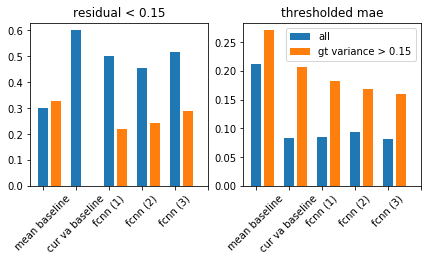

In [18]:
# plot results
names = ['mean baseline', 'cur va baseline', 'fcnn (1)', 'fcnn (2)', 'fcnn (3)']
predictions = [mean_baseline, cur_va_baseline, fcnn['sl1']['pred_val'],
              fcnn['sl2']['pred_val'], fcnn['sl3']['pred_val']]

fig, axes = plt.subplots(1,2, figsize=(7,3))
ax = axes[0]
ax.set_title('residual < 0.15')
scores = [losses.binary_regression_acc_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all')
scores = [losses.binary_regression_acc_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='gt variance > 0.15')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=45)

ax = axes[1]
ax.set_title('thresholded mae')
scores = [losses.thresholded_mae_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all')
scores = [losses.thresholded_mae_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='gt variance > 0.15')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=45)

axes[-1].legend()

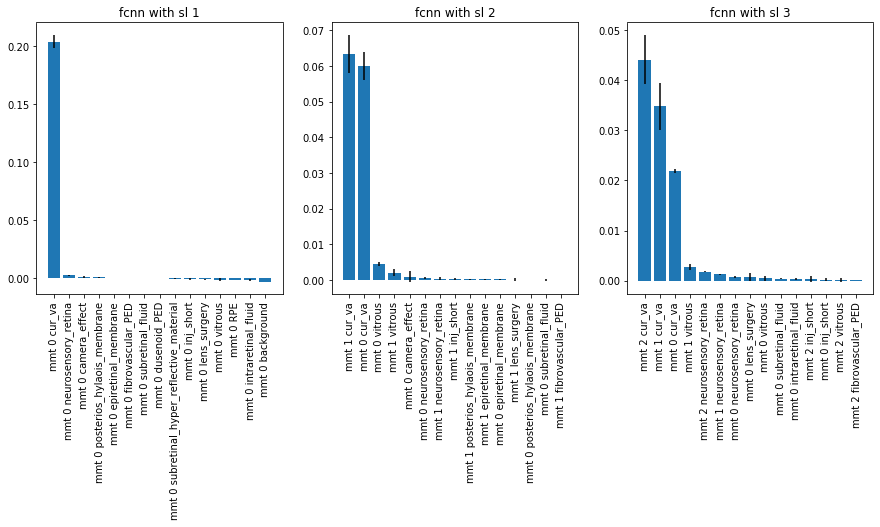

In [261]:
# plot feature importances
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.set_title('fcnn with sl {}'.format(i+1))
    exp = fcnn['sl{}'.format(i+1)]['feature_importance']
    ax.bar(exp.index[:15], exp.weight[:15], yerr=exp['std'][:15])
    ax.set_xticks(exp.index[:15])
    ax.set_xticklabels(exp.feature[:15], rotation=90)

# Train FCNN without current VA

In [262]:
cur_config = deepcopy(default_config)
cur_config['sequence_data']['load_sequences'] = True
cur_config['model']['input_vars'] = [IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES]
feature_names = [io_var.value for io_var in cur_config['model']['input_vars'][:-1]]
feature_names += Measurement.FEATURES
fcnn_nova = {}
for sl in (1,2,3):
    cur_config['model']['sequence_length'] = sl
    cur_feature_names = ['mmt {} {}'.format(i, n) for i in range(sl) for n in feature_names]

    est = Estimator(cur_config)
    # train model
    history = est.train_model(verbose=1)
    pred = est.predict_model(est.val_dataset)
    
    # get feature permutation importance
    # get reshaped model and dataset for use with eli5
    el_x, el_y = reshaped_dataset(est.val_dataset)
    score_func = get_score_func_for_eli5(est)
    base_score, score_decreases = eli5.permutation_importance.get_score_importances(score_func, el_x, el_y)
    feature_importances = np.mean(score_decreases, axis=0)
    feature_importances_std = np.std(score_decreases, axis=0)
    res = pd.DataFrame({'feature': cur_feature_names, 'weight': feature_importances, 'std': feature_importances_std})
    res = res.sort_values('weight', ignore_index=True, ascending=False)
    fcnn_nova['sl{}'.format(sl)] = {'pred_val': pred, 'feature_importance': res}
    

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 486.20it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)
INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'c

resulting norm values [None, None, None, None, None]
Epoch 1/30
8/8 [==============================] - 1s 96ms/step - loss: 0.2863 - thresholded_mae_last_fn: 0.3807 - binary_regression_acc_last_fn: 0.2083 - val_loss: 0.1588 - val_thresholded_mae_last_fn: 0.2259 - val_binary_regression_acc_last_fn: 0.2891
Epoch 2/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1299 - thresholded_mae_last_fn: 0.2453 - binary_regression_acc_last_fn: 0.2069 - val_loss: 0.1250 - val_thresholded_mae_last_fn: 0.2173 - val_binary_regression_acc_last_fn: 0.2614
Epoch 3/30
8/8 [==============================] - 0s 54ms/step - loss: 0.0982 - thresholded_mae_last_fn: 0.2017 - binary_regression_acc_last_fn: 0.2512 - val_loss: 0.1102 - val_thresholded_mae_last_fn: 0.2261 - val_binary_regression_acc_last_fn: 0.2317
Epoch 4/30
8/8 [==============================] - 0s 57ms/step - loss: 0.0870 - thresholded_mae_last_fn: 0.1908 - binary_regression_acc_last_fn: 0.2699 - val_loss: 0.1036 - val_thresholded

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:13<00:00, 480.58it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 101ms/step - loss: 0.5482 - thresholded_mae_last_fn: 0.5628 - binary_regression_acc_last_fn: 0.1352 - val_loss: 0.1606 - val_thresholded_mae_last_fn: 0.2366 - val_binary_regression_acc_last_fn: 0.2515
Epoch 2/30
8/8 [==============================] - 0s 59ms/step - loss: 0.1748 - thresholded_mae_last_fn: 0.2935 - binary_regression_acc_last_fn: 0.2016 - val_loss: 0.1814 - val_thresholded_mae_last_fn: 0.2308 - val_binary_regression_acc_last_fn: 0.3465
Epoch 3/30
8/8 [==============================] - 0s 55ms/step - loss: 0.1339 - thresholded_mae_last_fn: 0.2131 - binary_regression_acc_last_fn: 0.2837 - val_loss: 0.1536 - val_thresholded_mae_last_fn: 0.2817 - val_binary_regression_acc_last_fn: 0.1980
Epoch 4/30
8/8 [==============================] - 0s 53ms/step - loss: 0.1150 - thresholded_mae_last_fn: 0.2296 - binary_regression_acc_last_fn: 0.2126 - val_loss: 0.1351 - val_thresholded_mae_last_fn: 0.2281 - val_binary_regression_acc_las

INFO:Estimator:Loading sequences from ../../workspace/sequences_with_checkup_3-12_dict.pickle
INFO:Estimator:Removing 2 checkups from sequences
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences
100%|██████████| 6284/6284 [00:12<00:00, 508.65it/s]
INFO:Estimator:Splitting sequences of len 3-None into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 3654 train (76.3%), 505 val (10.5%), 629 test (13.1%)


resulting norm values [None, None, None, None, None]


INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.INJ_SHORT: 'inj_short'>, <IOVar.LENS_SURGERY: 'lens_surgery'>, <IOVar.ALL_FEATURES: 'all_features'>] and outputs [<IOVar.CHECKUP2_CUR_VA: 'checkup2_cur_va'>]
INFO:SimpleANNModel:{
    "encoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "dense_layers": {
        "num_layers": 2,
        "units": 64,
        "activation": "relu",
        "log": false
    },
    "decoder_layers": {
        "num_layers": 0,
        "units": 32,
        "activation": "relu",
        "log": false
    },
    "output_layer": {
        "units": 1,
        "activation": null,
        "log": false
    }
}


Epoch 1/30
8/8 [==============================] - 1s 93ms/step - loss: 0.4310 - thresholded_mae_last_fn: 0.4836 - binary_regression_acc_last_fn: 0.1941 - val_loss: 0.1955 - val_thresholded_mae_last_fn: 0.3283 - val_binary_regression_acc_last_fn: 0.1782
Epoch 2/30
8/8 [==============================] - 0s 53ms/step - loss: 0.1762 - thresholded_mae_last_fn: 0.2843 - binary_regression_acc_last_fn: 0.2275 - val_loss: 0.1549 - val_thresholded_mae_last_fn: 0.2202 - val_binary_regression_acc_last_fn: 0.3168
Epoch 3/30
8/8 [==============================] - 1s 77ms/step - loss: 0.1209 - thresholded_mae_last_fn: 0.2313 - binary_regression_acc_last_fn: 0.2263 - val_loss: 0.1248 - val_thresholded_mae_last_fn: 0.2054 - val_binary_regression_acc_last_fn: 0.2752
Epoch 4/30
8/8 [==============================] - 0s 52ms/step - loss: 0.0965 - thresholded_mae_last_fn: 0.1967 - binary_regression_acc_last_fn: 0.2772 - val_loss: 0.1141 - val_thresholded_mae_last_fn: 0.2094 - val_binary_regression_acc_last

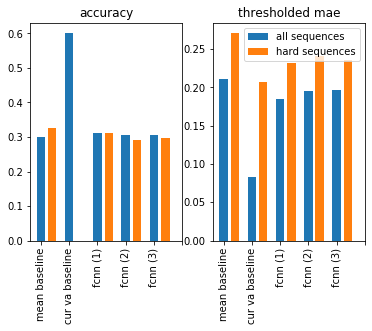

In [265]:
# plot results
names = ['mean baseline', 'cur va baseline', 'fcnn (1)', 'fcnn (2)', 'fcnn (3)']
predictions = [mean_baseline, cur_va_baseline, fcnn_nova['sl1']['pred_val'],
              fcnn_nova['sl2']['pred_val'], fcnn_nova['sl3']['pred_val']]

fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.set_title('accuracy')
scores = [losses.binary_regression_acc_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all sequences')
scores = [losses.binary_regression_acc_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='hard sequences')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=90)

ax = axes[1]
ax.set_title('thresholded mae')
scores = [losses.thresholded_mae_last_numpy(y_true, pred) for pred in predictions]
ax.bar(np.arange(len(scores)), scores, width=0.3, label='all sequences')
scores = [losses.thresholded_mae_last_numpy(y_true[mask_hard], pred[mask_hard]) for pred in predictions]
ax.bar(np.arange(len(scores))+0.4, scores, width=0.3, label='hard sequences')
ax.set_xticks(np.arange(len(scores)+0.5))
ax.set_xticklabels(names, rotation=90)

axes[-1].legend()

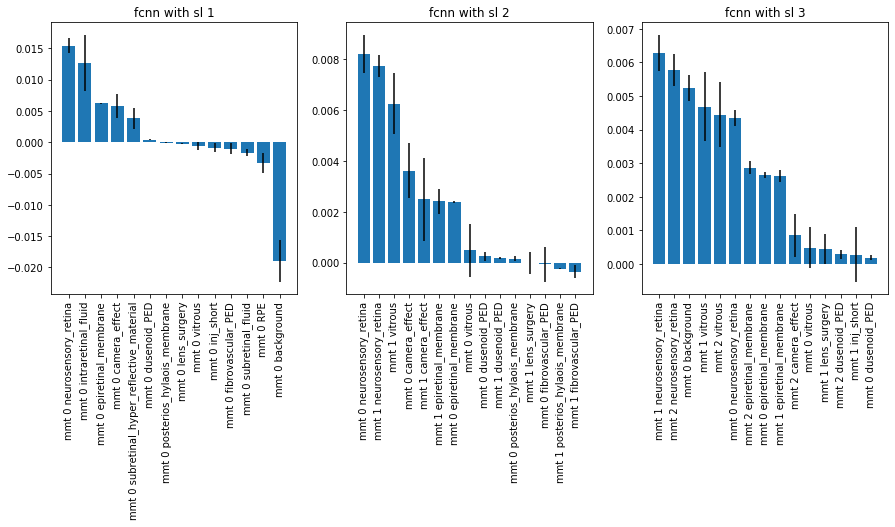

In [264]:
# plot feature importances
fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, ax in enumerate(axes):
    ax.set_title('fcnn with sl {}'.format(i+1))
    exp = fcnn_nova['sl{}'.format(i+1)]['feature_importance']
    ax.bar(exp.index[:15], exp.weight[:15], yerr=exp['std'][:15])
    ax.set_xticks(exp.index[:15])
    ax.set_xticklabels(exp.feature[:15], rotation=90)